# Projeto: Algoritmo de Sequenciamento de Produção com Otimização de Setup

Este projeto tem como objetivo implementar um algoritmo de sequenciamento de ordens de produção, levando em consideração aspectos como tempos de produção, prioridades de entrega e uma matriz de aproveitamento (setup entre produtos).

In [480]:
!jupyter nbconvert Sequenciamento_S2.ipynb --to html --template lab --HTMLExporter.theme=dark

[NbConvertApp] Converting notebook Sequenciamento_S2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 2359121 bytes to Sequenciamento_S2.html


### 🔹 1. Importação das bibliotecas

In [417]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

Bibliotecas amplamente consolidadas na análise e manipulação de dados:
- `pandas`: para estrutura e leitura de dados tabulares;
- `numpy`: para cálculos matriciais e numéricos;
- `itertools`: útil na geração de combinações e permutações;
- `matplotlib`: visualização de resultados;
- `random`: utilizado para gerar soluções iniciais aleatórias;
- `tqdm`: inserção de barra de progresso para feedback visual em loops.

In [415]:
# Leitura dos dados
file_path = 'production_df.xlsx'

df_geral = pd.read_excel(file_path, sheet_name='geral')
df_tempos = pd.read_excel(file_path, sheet_name='tempos')
df_setup_matrix = pd.read_excel(file_path, sheet_name='matriz_aproveitamento', index_col=0)

A estrutura da planilha foi desenhada com três abas principais:
- `geral`: armazena as ordens de produção com colunas como: Ordem, Material, Quantidade, Data de Necessidade, Prioridade.
- `tempos`: traz os tempos necessários para produção de cada item por unidade.
- `matriz_aproveitamento`: é a matriz de setup entre produtos. Aqui, quanto maior o valor, melhor o aproveitamento (menor tempo perdido em troca de produção).

Definindo o `index_col=0` na matriz para facilitar buscas diretas entre linhas e colunas pelos materiais.

### 🔹 3. Visualização inicial das ordens de produção

In [426]:
df_geral.head(10)

,Ordem,Material,Quantidade,Data de Necessidade,Prioridade
0,1800001,91688X,210,2025-04-07,0.0
1,1800002,60987X,180,2025-05-13,0.5
2,1800003,91688X,580,2025-05-20,0.0
3,1800004,22980X,170,2025-05-04,1.0
4,1800005,60987X,290,2025-05-01,0.0
5,1800006,66325X,500,2025-04-04,0.0
6,1800007,23393X,600,2025-04-08,0.0
7,1800008,96678X,480,2025-05-20,0.0
8,1800009,97853X,220,2025-05-06,0.0
9,1800010,05768X,350,2025-03-29,0.0


Aqui, faço a inspeção visual das 10 primeiras ordens para garantir que o carregamento ocorreu como esperado e que os dados estão estruturados corretamente seguindo o objetivo de sempre examinar amostras antes de prosseguir com lógica de processamento.

### 🔹 4. Ajustes de dados e preenchimentos auxiliares

In [441]:
# Merge dos tempos com dados gerais
df = df_geral.merge(df_tempos, on='Material', how='left')

Combina (`merge`) o DataFrame `df_geral` com `df_tempos`, usando a coluna `"Material"` como chave de junção.  
O merge do tipo `left` garante que todas as ordens em `df_geral` apareçam, trazendo os tempos se houver correspondência.

In [443]:
# Tempo de produção (tempo por peça * quantidade)
df['tempo_producao'] = df['Tempo por Peça'] * df['Quantidade']

Cria a coluna `"tempo_producao"`, calculando o tempo total de produção para cada ordem.  
É obtido multiplicando o `"Tempo por Peça"` pela `"Quantidade"` de peças daquela ordem.

In [383]:
df.head()

,Ordem,Material,Quantidade,Data de Necessidade,Prioridade,Tempo por Peça,Tempo Setup,tempo_producao
0,1800001,91688X,210,2025-04-07,0.0,5,60,1050
1,1800002,60987X,180,2025-05-13,0.5,7,60,1260
2,1800003,91688X,580,2025-05-20,0.0,5,60,2900
3,1800004,22980X,170,2025-05-04,1.0,4,60,680
4,1800005,60987X,290,2025-05-01,0.0,7,60,2030


Exibe as primeiras linhas do DataFrame resultante (`df`) para conferir as novas colunas e cálculos.  
Agora cada ordem deve ter suas colunas originais mais `"Tempo por Peça"`, `"Tempo Setup"` e `"tempo_producao"`.

In [385]:
df = df.head(8)

Aqui limitamos o conjunto de ordens a apenas as 8 primeiras.  
Isso é feito para simplificar a próxima etapa, pois o número de sequências possíveis cresce fatorialmente com o número de ordens.  
Com 8 ordens, teremos `8!` (`40.320`) sequências para avaliar, o que é manejável.  
Com todas as ordens, seria impossível (`29!` é um número gigantesco). 

In [387]:
df

,Ordem,Material,Quantidade,Data de Necessidade,Prioridade,Tempo por Peça,Tempo Setup,tempo_producao
0,1800001,91688X,210,2025-04-07,0.0,5,60,1050
1,1800002,60987X,180,2025-05-13,0.5,7,60,1260
2,1800003,91688X,580,2025-05-20,0.0,5,60,2900
3,1800004,22980X,170,2025-05-04,1.0,4,60,680
4,1800005,60987X,290,2025-05-01,0.0,7,60,2030
5,1800006,66325X,500,2025-04-04,0.0,5,120,2500
6,1800007,23393X,600,2025-04-08,0.0,2,120,1200
7,1800008,96678X,480,2025-05-20,0.0,5,60,2400


Mostra as 8 ordens selecionadas (todas as colunas), confirmando quais ordens e dados serão consideradas nas próximas etapas.

### 🔁 3. Função para Calcular o Tempo Total de Setup de uma Sequência
Aqui entra a lógica que leva em conta o setup dinâmico, com base na sequência:

In [452]:
# Função para calcular o tempo total de setup de uma sequência de ordens
def calcular_tempo_setup_total(sequencia, df, matriz_setup):
    total_setup = 0
    ordem_anterior = None
    
    for ordem in sequencia:
        linha = df[df['Ordem'] == ordem].iloc[0]
        mat_atual = linha['Material']
        tempo_setup_base = linha['Tempo Setup']
        
        if ordem_anterior is None:
            # Primeira ordem sempre exige setup total
            tempo_setup = tempo_setup_base
        else:
            mat_anterior = df[df['Ordem'] == ordem_anterior].iloc[0]['Material']
            fator = matriz_setup.loc[mat_anterior, mat_atual]
            tempo_setup = tempo_setup_base * fator
        
        total_setup += tempo_setup
        ordem_anterior = ordem

    return total_setup

Define uma função que calcula o tempo total de setup para uma sequência específica de ordens de produção.  
O objetivo é considerar o efeito de sequência: setups consecutivos podem ser otimizados se o material seguinte for similar ao anterior     

### ⚖️ 4. Definição dos Pesos Proporcionais por Critério

In [391]:
pesos = {
    'setup': 10,
    'prioridade': 80,
    'data': 10
}

Aqui definimos o peso (importância relativa) de cada critério na avaliação da sequência:
- `'setup'`: peso para o tempo de setup total.
- `'prioridade'`: peso para o critério de prioridade das ordens.
- `'data'`: peso para o critério de cumprimento das datas de necessidade.
Valores maiores indicam que o critério é mais importante na composição da pontuação final.

Considerando o grau de relevância das variáveis, considerei atribuir muito peso a variável `'prioridade'` (fator mais importante) e aplicar pesos consideravelmente menores para as variáveis `'setup'` e `data'`.

Aqui, a definição traz consigo uma certa objetividade, uma vez que, o grau de relevância das variáveis pode ser visto por diferentes óticas dependendo do contexto da empresa, assim como diversos outros fatores subjetivos.


### 🔁 5. Avaliação de Todas as Permutações Possíveis

In [393]:
# Lista com todas as ordens
ordens = df['Ordem'].tolist()

# Lista para armazenar valores brutos por sequência
valores_brutos = []

# Loop para calcular os valores brutos (sem normalização)
for sequencia in tqdm(itertools.permutations(ordens), desc="Calculando valores brutos"):
    setup_total = calcular_tempo_setup_total(sequencia, df, df_setup_matrix)
    prioridade_total = 0
    data_total = 0

    for i in range(len(sequencia)):
        ordem_i = sequencia[i]
        linha_i = df[df['Ordem'] == ordem_i].iloc[0]
        data_i = linha_i['Data de Necessidade']
        prioridade_i = linha_i['Prioridade']

        for j in range(i):
            ordem_j = sequencia[j]
            linha_j = df[df['Ordem'] == ordem_j].iloc[0]
            data_j = linha_j['Data de Necessidade']
            prioridade_j = linha_j['Prioridade']

            # Penalidade por prioridade: ordens mais prioritárias depois de menos prioritárias
            if prioridade_i > prioridade_j:
                prioridade_total += (prioridade_i - prioridade_j)

            # Penalidade por data: ordens com data mais próxima depois de ordens com data tardia
            if data_i < data_j:
                atraso = (data_j - data_i).days
                data_total += atraso

    valores_brutos.append({
        'sequencia': sequencia,
        'setup': setup_total,
        'prioridade': prioridade_total,
        'data': data_total
    })

Calculando valores brutos: 40320it [04:22, 153.31it/s]


Aqui são avaliadas todas as sequências possíveis (permutações) das 8 ordens selecionadas.  
Para cada sequência, calcularemos três valores "brutos":
- Tempo total de setup para a sequência (somando setups dependendo da ordem dos materiais).
- Penalização de prioridade: quanto a sequência desrespeita a ordem de prioridade desejada.
- Penalização de atraso de data: quanto a sequência pode causar atrasos em ordens com datas mais urgentes.
  
Observação: o número de sequências a avaliar é `8! = 40.320`. Usamos `tqdm` para acompanhar o progresso do loop.

### 📊 6. Cálculo dos Máximos para Normalização

In [493]:
# Descobre os maiores valores de cada critério
max_setup = max(x['setup'] for x in valores_brutos)
max_prioridade = max(x['prioridade'] for x in valores_brutos)
max_data = max(x['data'] for x in valores_brutos)

Agora que temos os valores brutos de cada critério para todas as sequências, vamos encontrar o maior valor observado de cada critério. 
Esses máximos representarão o "pior caso" para cada métrica e serão usados para normalizar os valores (escala 0 a 1).

### 🧠 7. Aplicação da Normalização e Cálculo do Fitness Final

In [495]:
# Aplica a normalização [0, 1] e pesos proporcionais
resultados_normalizados = []

for i, entrada in enumerate(valores_brutos):
    setup_norm = entrada['setup'] / max_setup if max_setup > 0 else 0
    prioridade_norm = entrada['prioridade'] / max_prioridade if max_prioridade > 0 else 0
    data_norm = entrada['data'] / max_data if max_data > 0 else 0

    fitness = (
        pesos['setup'] * setup_norm +
        pesos['prioridade'] * prioridade_norm +
        pesos['data'] * data_norm
    )

    resultados_normalizados.append({
        'seq_id': i,
        'sequencia': entrada['sequencia'],
        'fitness': fitness,
        'setup': entrada['setup'],
        'prioridade': entrada['prioridade'],
        'data': entrada['data']
    })

Com os máximos em mãos, podemos normalizar cada critério de cada sequência, transformando-os em valores entre 0 e 1 (proporção em relação ao pior caso).  
Então aplicamos os pesos definidos para calcular uma pontuação final `"fitness"` para cada sequência.

### 📋 8. Resultados Finais: Ordenando pela Melhor Sequência

In [499]:
# DataFrame final com todas as sequências avaliadas
df_resultados_normalizados = pd.DataFrame(resultados_normalizados).sort_values(by='fitness').reset_index(drop=True)

# Exibe as 10 melhores sequências
df_resultados_normalizados.head(10)

,seq_id,sequencia,fitness,setup,prioridade,data
0,16274,"(1800004, 1800002, 1800006, 1800007, 1800001, ...",4.778772,60.0,0.0,209
1,16275,"(1800004, 1800002, 1800006, 1800007, 1800001, ...",4.778772,60.0,0.0,209
2,15926,"(1800004, 1800002, 1800001, 1800007, 1800006, ...",4.871795,60.0,0.0,215
3,15927,"(1800004, 1800002, 1800001, 1800007, 1800006, ...",4.871795,60.0,0.0,215
4,16272,"(1800004, 1800002, 1800006, 1800007, 1800001, ...",5.073345,60.0,0.0,228
5,16277,"(1800004, 1800002, 1800006, 1800007, 1800001, ...",5.073345,60.0,0.0,228
6,16285,"(1800004, 1800002, 1800006, 1800007, 1800005, ...",5.150865,60.0,0.0,233
7,16284,"(1800004, 1800002, 1800006, 1800007, 1800005, ...",5.150865,60.0,0.0,233
8,16404,"(1800004, 1800002, 1800007, 1800006, 1800005, ...",5.212880,60.0,0.0,237
9,16405,"(1800004, 1800002, 1800007, 1800006, 1800005, ...",5.212880,60.0,0.0,237


Vamos agora organizar os resultados para identificar as melhores sequências segundo o critério de fitness.  
Quanto **menor** o valor de fitness melhor a sequência, pois significa menor tempo de setup, menos atraso e ordens prioritárias sendo atendidas primeiro, considerando os pesos atribuídos).

In [573]:
# Retorna a tupla contendo as ordens na melhor sequência encontrada.
df_resultados_normalizados['sequencia'].iloc[0]

(1800004, 1800002, 1800006, 1800007, 1800001, 1800005, 1800003, 1800008)

Aqui, temos o resultado da **sequência ótima** (a sequência da primeira linha do DataFrame, que tem o menor fitness).

### 📋 9. Detalhamento da lógica do modelo de penalização (fitness)
Para explicar de maneira mais detalhada, vamos pegar alguns resultados randômicos e aplicar novamente o cálculo do fitness.

In [501]:
df_res = df_resultados_normalizados
# Ordena por fitness (menor é melhor)
df_res = df_res.sort_values('fitness').reset_index(drop=True)

# Usa semente para reprodutibilidade
df_amostras = df_res.sample(5, random_state=42).reset_index(drop=True)

# Exibe todas as métricas: brutos, normalizados e ponderados para cada amostra
print("Análise de 5 sequências aleatórias com fitness detalhado:")
print(df_amostras.to_string(index=False))

Análise de 5 sequências aleatórias com fitness detalhado:
 seq_id                                                                sequencia   fitness  setup  prioridade  data
  39649 (1800008, 1800007, 1800001, 1800004, 1800002, 1800003, 1800006, 1800005) 49.164862  240.0         4.5   330
  28622 (1800006, 1800005, 1800007, 1800003, 1800004, 1800002, 1800001, 1800008) 57.885886  180.0         6.0   177
  33047 (1800007, 1800004, 1800008, 1800002, 1800006, 1800005, 1800003, 1800001) 25.866554  150.0         2.0   334
  39721 (1800008, 1800007, 1800002, 1800001, 1800003, 1800004, 1800006, 1800005) 55.454728  120.0         5.5   391
  14469 (1800003, 1800008, 1800001, 1800005, 1800007, 1800004, 1800006, 1800002) 76.389292   90.0         8.0   433


Analisando o resultado gerado, podemos observar as penalizações dadas pelos atributos `setup`, `prioridade` e `data` e como elas se refletem na penalização final (fitness).

In [561]:
 seq_id = 33047  
 sequencia = (1800007, 1800004, 1800008, 1800002, 1800006, 1800005, 1800003, 1800001)  
 setup = 150.0  
 prioridade = 2.0  
 data = 334  
 fitness = 25.866554

Vamos aqui, usar como exemplo a terceira linha de `seq_id` *33047*.

##### Identificação dos “piores casos”:
Antes de normalizar, calculamos os maiores valores observados em todas as 40 320 permutações:

In [563]:
max_setup      = max(x['setup']      for x in valores_brutos)
max_prioridade = max(x['prioridade'] for x in valores_brutos)
max_data       = max(x['data']       for x in valores_brutos)

##### Normalização de cada critério:
Cada valor bruto é convertido numa proporção entre 0 e 1, dividindo pelo respectivo máximo:

In [565]:
setup_norm      = 150.0 / max_setup
prioridade_norm =  2.0 / max_prioridade
data_norm       = 334   / max_data

Esse passo garante comparabilidade entre critérios com escalas diferentes.

##### Aplicação dos pesos:
Atribuímos importância relativa a cada métrica:

In [567]:
pesos = {'setup': 10, 'prioridade': 80, 'data': 10}

Em seguida, multiplicamos cada valor normalizado pelo seu peso:

In [569]:
w_setup      = pesos['setup']      * setup_norm
w_prioridade = pesos['prioridade'] * prioridade_norm
w_data       = pesos['data']       * data_norm

##### Cálculo do fitness:
Por fim, somamos as contribuições ponderadas:

In [571]:
fitness = w_setup + w_prioridade + w_data
fitness

25.86655368295515

O resultado compara cada sequência ao “pior caso” em termos de tempo de setup, atraso e prioridade, combinando tudo numa única pontuação.

### 10. 🎨 Visualização dos Resultados (Gráficos)

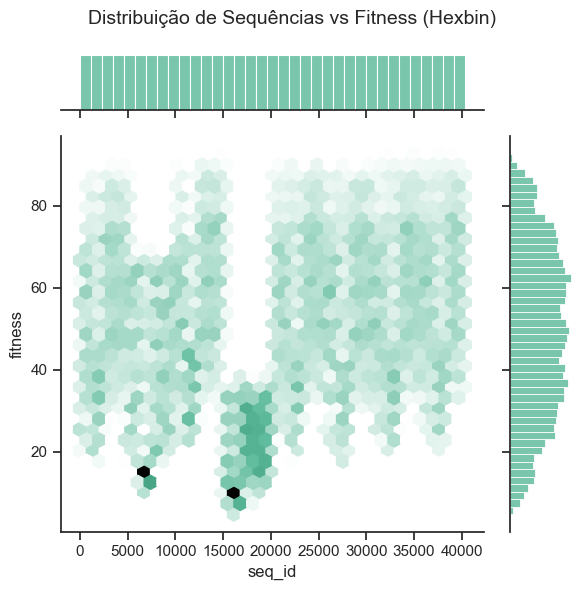

In [578]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# jointplot de densidade hexagonal (mapa de calor com hexágonos)
sns.jointplot(
    data=df_resultados_normalizados,
    x='seq_id',
    y='fitness',
    kind='hex',              # densidade com hexágonos
    color="#4CB391",         # cor (verde-azulado)
    height=6,                # tamanho da figura
    gridsize=30              # tamanho dos hexágonos
)

plt.suptitle("Distribuição de Sequências vs Fitness (Hexbin)", fontsize=14)
plt.tight_layout()
plt.show()

Nesta etapa, criamos um gráfico que nos ajuda a enxergar, de forma imediata, como os valores de fitness se distribuem ao longo de todas as permutações (identificadas pelo seq_id).

O objetivo é visualizar a densidade de pontos (quantas sequências caem em determinada faixa de fitness) de maneira agregada, sem plotar cada ponto individualmente. É possível identificar faixas de fitness onde há maior concentração de sequências (hexágonos mais escuros) e onde há menos (hexágonos claros ou vazios).

Portanto, o resultado é uma visão de onde estão as melhores e piores regiões de fitness em relação ao ID da permutação, permitindo insights sobre padrões de densidade e auxiliando na escolha de parâmetros para futuras otimizações ou filtros.

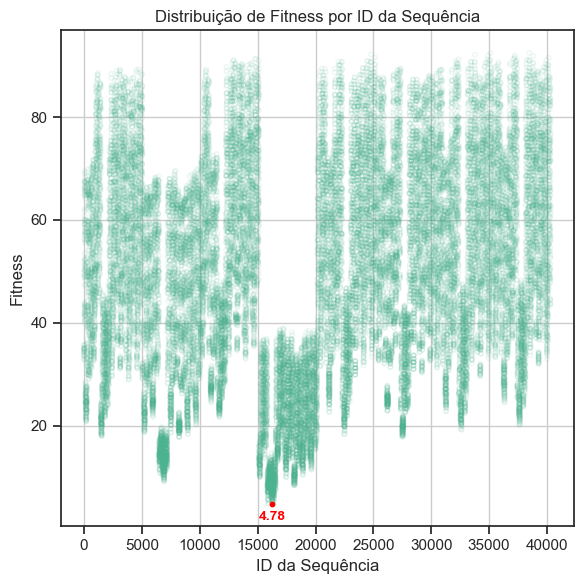

In [664]:
import matplotlib.pyplot as plt

# Dados
x = df_resultados_normalizados['seq_id']
y = df_resultados_normalizados['fitness']

# Índice do menor ponto
min_idx = y.idxmin()
x_min, y_min = x[min_idx], y[min_idx]

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, facecolors='none', edgecolors='#4CB391', s=10, alpha=0.1)
plt.scatter(x_min, y_min, color='red', s=10)  # destaque

# Anotação do valor mínimo
plt.text(x_min, y_min-1.5, f"{y_min:.2f}", 
         ha='center', va='top', fontweight='bold', color='red', size='small')

# Labels e grid
plt.title("Distribuição de Fitness por ID da Sequência")
plt.xlabel("ID da Sequência")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

Aqui, foi realizado o mesmo gráfico porém agora segregando cada resultado em um scatter plot com todas as combinações, e também, trazendo o melhor ID em destaque e como ele está disposto em relação aos demais resultados.

In [659]:
import altair as alt
import pandas as pd

# Evita erro do Altair com mais de 5000 linhas
alt.data_transformers.disable_max_rows()

# Garante que 'seq_id' seja numérico
df_resultados_normalizados['seq_id'] = pd.to_numeric(df_resultados_normalizados['seq_id'])

# Filtra apenas as linhas com seq_id entre 15000 e 20000
df_filtrado = df_resultados_normalizados[
    (df_resultados_normalizados['seq_id'] >= 15000) &
    (df_resultados_normalizados['seq_id'] <= 20000)
].copy()

# Gráfico Altair interativo
chart = alt.Chart(df_filtrado).mark_circle(
    size=200,
    opacity=0.5,
    color='#4CB391'
).encode(
    x=alt.X('seq_id', title='ID da Sequência'),
    y=alt.Y('fitness', title='Fitness Normalizado'),
    tooltip=['seq_id', 'fitness', 'setup', 'data']  # Tooltip ao passar o mouse
).properties(
    title='Distribuição de Fitness (IDs 15000–20000)',
    width=600,
    height=600
).interactive()  # Habilita zoom e pan

chart

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

Para trazer um pouco de interatividade, aqui foi realizado um gráfico com a library `altair` que permite a navegação do usuário como forma exploratória de melhor entendimento da dispersão dos pontos assim como suas características individuais ao sobrepor cada ponto.

Devido ao alto volume de resultados *(40320 resultados)*, foi necessário reduzir a exibição para uma quantidade menor de pontos que permitem o processamento. Assim, optei por expor a faixa dos IDs de *15.000 a 20.000*, faixa essa que apresentou os melhores resultados conforme vimos nos gráficos anteriores.

### 11. Conclusão Final

- A análise exploratória apontou as sequências que melhor equilibram a minimização de setup, o cumprimento de datas críticas e o aproveitamento de trocas de produção.  
- A normalização baseada no pior cenário padroniza métricas heterogêneas (tempo de processamento, atraso de entrega e prioridade), viabilizando comparações justas e coerentes.  
- Ajustes sutis nos pesos de cada critério podem gerar soluções ótimas distintas, sublinhando a necessidade de realizar análises de sensibilidade.

#### Limitações de Escalabilidade e Alternativas Metaheurísticas

Embora o método exaustivo de permutação total garanta encontrar a sequência ótima, **sua complexidade cresce em `n!`** — para apenas 10 ordens já são **3.628.800 possibilidades**. Em cenários industriais, onde dezenas ou centenas de ordens precisam ser reordenadas continuamente, esse volume de processamento torna o modelo **inviável** para uso em tempo real ou integrado a um ERP.

Como alternativa, **metaheurísticas** que não exploram todas as permutações surgem como opção prática. Um exemplo encontrado é o **Simulated Annealing**, que:
- Usa vizinhanças locais em vez de permutar globalmente todas as ordens;  
- Aplica um esquema de “resfriamento” probabilístico para escapar de mínimos locais;  
- Converge para uma boa solução em tempo controlável, mesmo para problemas de grande escala.

Adotar Simulated Annealing (ou outras heurísticas como algoritmos genéticos e busca tabu) permite **balancear qualidade de solução e desempenho computacional**, viabilizando a aplicação em ambientes de produção sem sacrificar drasticamente a eficiência operacional, sendo esse uma possibilidade futura para desenvolvimento e aplicação como continuidade a esse projeto.
